In [1]:
import pandas as pd
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
class GridWorldEnv(gym.Env):

    def __init__(self):

        # 0 = void, 1 = valid tile
        # convention: bottom left is (0, 0), top right is (N, N)
        self._grid = np.array([
            [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
            [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
            [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1],
            [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
            [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        ], dtype=np.int32)
        assert self._grid.shape[0] == self._grid.shape[1]

        # set to valid values in reset()
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)

        # Observations are dictionaries with the agent's and the target's location
        self.observation_space = gym.spaces.Box(low=0, high=len(self._grid), shape=self._grid.shape, dtype=np.int32)

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        # Dictionary maps the abstract actions to the directions on the grid
        self.action_space = gym.spaces.Discrete(4)
        self._action_to_direction = {
            0: np.array([1, 0], dtype=np.int32),  # up
            1: np.array([0, 1], dtype=np.int32),  # right
            2: np.array([-1, 0], dtype=np.int32),  # down
            3: np.array([0, -1], dtype=np.int32),  # left
        }

    def _get_obs(self):
        return self._agent_location
    
    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=2)}
    
    def _is_valid_state(self, state):
        return False if self._grid[len(self._grid) - state[0] - 1, state[1]] == 0 else True
        
    
    def _calc_new_state(self, state, action):

        # cannot move out of an invalid state or the target state
        if (not self._is_valid_state(state)) or np.array_equal(state, self._target_location):
            return state

        action_vector = self._action_to_direction[action]
        new_state = np.clip(state + action_vector, 0, len(self._grid) - 1)

        # don't move if action is invalid
        if not self._is_valid_state(new_state):
            new_state = state

        return new_state
    
    def _get_reward(self, state):

        # starting in an invalid grid location is undefined
        if not self._is_valid_state(state):
            return 0

        # reward = +1 if current state is target state, else 0
        return 1 if np.array_equal(state, self._target_location) else 0
    
    def reset(self, seed: int | None = None, options: dict | None = None):
        super().reset(seed=seed)

        # agent starts in bottom row, target is top right-ish
        self._agent_location = np.array([0, 7], dtype=np.int32)
        self._target_location = np.array([13, 12], dtype=np.int32)

        observation = self._get_obs()
        info = self._get_info()
        return observation, info
    
    def step(self, action: int):

        # move agent
        self._agent_location = self._calc_new_state(self._agent_location, action)

        # output
        terminated = np.array_equal(self._agent_location, self._target_location)
        truncated = False
        reward = 1 if terminated else 0
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

In [3]:
env = GridWorldEnv()

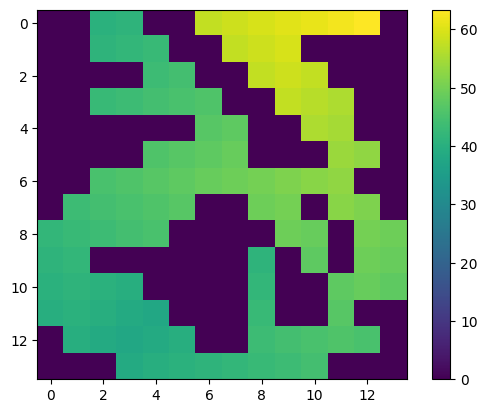

In [21]:
# hyperparams
gamma = 0.99

# init env
env.reset()
actions = np.arange(env.action_space.n)

# empty value function
V = pd.DataFrame(0.0, index=range(env._grid.shape[0]), columns=range(env._grid.shape[1]))

# run for some number of epochs
for _ in range(100):

    # "freeze" value function by copying it, then using that copy later on
    V2 = V.copy()

    # loop over all states
    for idx, _ in np.ndenumerate(V):
        state = np.array(idx)

        # find lookahead value based on greedy action
        max_value = 0.0
        for action in actions:
            reward = env._get_reward(state)
            new_state = env._calc_new_state(state, action)

            value = reward + gamma * V2.at[tuple(new_state)]
            if value > max_value:
                max_value = value

        V.at[tuple(state)] = max_value

# show learned value function
plt.imshow(V[::-1]) # need to flip vertically to look correct
plt.colorbar()
plt.show()

In [22]:
display(V[::-1].style.format('{:.2f}'))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
13,0.00,0.00,40.40,41.18,0.00,0.00,57.54,58.50,59.46,60.43,61.41,62.40,63.40,0.00
12,0.00,0.00,41.18,41.96,42.76,0.00,0.00,57.54,58.50,59.46,0.00,0.00,0.00,0.00
11,0.00,0.00,0.00,0.00,43.56,44.37,0.00,0.00,57.54,58.50,57.54,0.00,0.00,0.00
10,0.00,0.00,42.76,43.56,44.37,45.19,46.01,0.00,0.00,57.54,56.60,55.67,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,46.85,47.69,0.00,0.00,55.67,54.75,0.00,0.00
8,0.00,0.00,0.00,0.00,46.01,46.85,47.69,48.54,0.00,0.00,0.00,53.83,52.93,0.00
7,0.00,0.00,45.19,46.01,46.85,47.69,48.54,49.40,50.27,51.15,52.04,52.93,0.00,0.00
6,0.00,43.56,44.37,45.19,46.01,46.85,0.00,0.00,49.40,50.27,0.00,52.04,51.15,0.00
5,41.96,42.76,43.56,44.37,45.19,0.00,0.00,0.00,0.00,49.40,48.54,0.00,50.27,49.40
4,41.18,41.96,0.00,0.00,0.00,0.00,0.00,0.00,41.18,0.00,47.69,0.00,49.40,48.54


black = invalid states, gray = valid states, white = chosen path


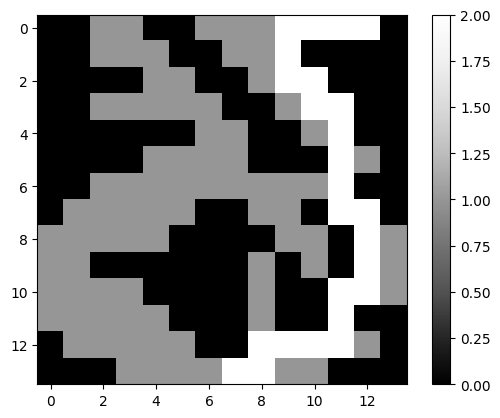

In [12]:
# init env
state, _ = env.reset()
actions = np.arange(env.action_space.n)

# start out the optimal policy's travelled path
path = pd.DataFrame(env._grid.copy()[::-1])
path.at[tuple(state)] = 2.0

# iterate through env and track path
for i in range(100):

    # get action that maximizes value function
    max_action = 0
    max_value = 0
    for action in actions:
        new_state = env._calc_new_state(state, action)
        value = V.at[tuple(new_state)]
        if value > max_value:
            max_value = value
            max_action = action

    # take that action & store the new state in the path
    state, _, terminated, _, _ = env.step(max_action)
    path.at[tuple(state)] = 2.0

    if terminated:
        break

# show path
print('black = invalid states, gray = valid states, white = chosen path')
plt.imshow(path[::-1], cmap='Greys_r')
plt.colorbar()
plt.show()